# Procesamiento de datos de Sentinel-2

## Librerías

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os


## Obtener los datos

In [62]:
filesNacionalesMean = glob.glob("data/sentinel/states/mean/*.csv")
filesNacionalesSum = glob.glob("data/sentinel/states/sum/*.csv")
filesNacionalesSum[:5]

['data/sentinel/states/sum\\CO_sum_2018-01-01.csv',
 'data/sentinel/states/sum\\CO_sum_2019-01-01.csv',
 'data/sentinel/states/sum\\CO_sum_2020-01-01.csv',
 'data/sentinel/states/sum\\CO_sum_2021-01-01.csv',
 'data/sentinel/states/sum\\CO_sum_2022-01-01.csv']

### Diccionarios complementarios

In [5]:
replace_emision = {
  'pm10': '$PM_{10}$',
  'pm2.5': '$PM_{2.5}$',
  'co': '$CO$',
  'nox':'$NO_x$',
  'cov':'$COV$',
  'nh3':'$NH_3$',
  'so2':"$SO_2$",
  'no2':"$NO_2$",
  'o3':"$O_3$",
  'hcho':"$HCHO$",
}


In [64]:
filesNacionalesSum[0].split("_")[2][:10]

'2018-01-01'

## Preparar función de lectura

In [77]:
def readFileSentinel(path, dfFull, kind):
  cols_to_keep = ['ADM1_NAME',kind]
  name_Quimico = path.split("\\")[1].split("_")[0].lower()
  date = path.split("_")[2][:10]

  df = pd.read_csv(path)
  df = df.drop(columns=["ADM1_CODE","ADM0_CODE","EXP1_YEAR","system:index","STR1_YEAR","STATUS","ADM0_NAME","DISP_AREA"])
  #df.rename(columns={kind: replace_emision[name_Quimico]}, inplace=True)

  df['date'] = date
  df['quimico'] = replace_emision[name_Quimico]
  # check if dfFull is empty
  if dfFull.empty:
    return df
  
  # merge dataframes by ADM1_NAME
  dfFull = pd.concat([dfFull, df], axis=0, ignore_index=True)
  
  return dfFull

## Leer datos 

### Datos de acumulado (anuales por estado)

In [78]:
dfFullSum = pd.DataFrame()

for path in filesNacionalesSum:
  
  dfFullSum = readFileSentinel(path, dfFullSum, 'sum')
  
dfFullSum.head()

,sum,Shape_Leng,Shape_Area,ADM1_NAME,date,quimico
0,3195.479256,2.805149,0.455086,Aguascalientes,2018-01-01,$CO$
1,75393.481781,31.487146,6.921294,Baja California,2018-01-01,$CO$
2,68894.335963,56.050239,6.405150,Baja California Sur,2018-01-01,$CO$
3,48385.760098,25.072991,4.888117,Campeche,2018-01-01,$CO$
4,59911.511820,15.500275,6.231878,Chiapas,2018-01-01,$CO$


## Ajustar datos geográficos

### AGEBS Colima

In [38]:
agebs_area = pd.read_csv("data/06_colima/agebs_area.csv")
agebs_area.head()

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,area
0,0600100010081,6,1,1,0081,0.28
1,060010001019A,6,1,1,019A,0.15
2,0600100010359,6,1,1,0359,0.05
3,0600100010151,6,1,1,0151,0.42
4,0600100010166,6,1,1,0166,0.41


### Municipios Nacional

In [14]:
files_nacional = glob.glob("data/mexico/*.csv")
files_nacional

['data/mexico\\areas_geoestadisticas_municipales.csv',
 'data/mexico\\localidades_urbanas_y_rurales_amanzanadas.csv']

In [21]:
mun_nacional = pd.read_csv("data/mexico/areas_geoestadisticas_municipales.csv", skiprows=2, encoding="latin-1")
mun_nacional.rename(columns={
  "Clave Geoestadística Estatal": "CVE_ENT", 
  "Clave Geoestadística Municipal": "CVE_MUN", 
  "Nombre del Municipio": "NOM_MUN", 
  "Nombre del Estado": "NOM_ENT"}, inplace=True)

mun_colima = mun_nacional[mun_nacional["CVE_ENT"] == 6]
mun_colima.head()

,CVE_ENT,NOM_ENT,CVE_MUN,NOM_MUN
74,6,Colima,1,Armería
75,6,Colima,2,Colima
76,6,Colima,3,Comala
77,6,Colima,4,Coquimatlán
78,6,Colima,5,Cuauhtémoc


### Localidades Nacional

In [56]:
loc_nacional = pd.read_csv("data/mexico/localidades_urbanas_y_rurales_amanzanadas.csv", skiprows=2, encoding="latin-1")
loc_nacional.rename(columns={
  "Clave Geoestadística Estatal": "CVE_ENT", 
  "Clave Geoestadís  tica Municipal": "CVE_MUN", 
  "Clave Geoestadística de Localidad": "CVE_LOC",
  "Nombre de Localidad": "NOM_LOC",
  "AGEB":'CVE_AGEB'}, inplace=True)
loc_nacional.drop(columns=["Unnamed: 6","CVE_AGEB"], inplace=True)
loc_nacional = loc_nacional[loc_nacional["CVE_ENT"] == 6]
loc_nacional.head()

,CVE_ENT,CVE_MUN,CVE_LOC,NOM_LOC,Ámbito
2455,6,1,1,Ciudad de Armería,U
2456,6,1,7,Cofradía de Juárez,U
2457,6,1,9,Cuyutlán,R
2458,6,1,32,El Paraíso [Balneario],R
2459,6,1,33,Periquillo,R


### Merge localidades y municipios

In [57]:
colima = pd.merge(mun_colima, loc_nacional, on=["CVE_ENT", "CVE_MUN"])
colima

,CVE_ENT,NOM_ENT,CVE_MUN,NOM_MUN,CVE_LOC,NOM_LOC,Ámbito
0,6,Colima,1,Armería,1,Ciudad de Armería,U
1,6,Colima,1,Armería,7,Cofradía de Juárez,U
2,6,Colima,1,Armería,9,Cuyutlán,R
3,6,Colima,1,Armería,32,El Paraíso [Balneario],R
4,6,Colima,1,Armería,33,Periquillo,R
...,...,...,...,...,...,...,...
161,6,Colima,10,Villa de Álvarez,22,El Mixcuate,R
162,6,Colima,10,Villa de Álvarez,24,El Naranjal,R
163,6,Colima,10,Villa de Álvarez,37,Pueblo Nuevo,R
164,6,Colima,10,Villa de Álvarez,86,El Nuevo Naranjal,R


In [58]:
agebs_area

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,area
0,0600100010081,6,1,1,0081,0.28
1,060010001019A,6,1,1,019A,0.15
2,0600100010359,6,1,1,0359,0.05
3,0600100010151,6,1,1,0151,0.42
4,0600100010166,6,1,1,0166,0.41
...,...,...,...,...,...,...
546,0601000011017,6,10,1,1017,0.21
547,0601000011178,6,10,1,1178,0.08
548,0601000011144,6,10,1,1144,0.39
549,060100001113A,6,10,1,113A,0.32


In [59]:
agebs_colima = pd.merge(agebs_area, colima, on=["CVE_ENT", "CVE_MUN", "CVE_LOC"])
agebs_colima

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,area,NOM_ENT,NOM_MUN,NOM_LOC,Ámbito
0,0600100010081,6,1,1,0081,0.28,Colima,Armería,Ciudad de Armería,U
1,060010001019A,6,1,1,019A,0.15,Colima,Armería,Ciudad de Armería,U
2,0600100010359,6,1,1,0359,0.05,Colima,Armería,Ciudad de Armería,U
3,0600100010151,6,1,1,0151,0.42,Colima,Armería,Ciudad de Armería,U
4,0600100010166,6,1,1,0166,0.41,Colima,Armería,Ciudad de Armería,U
...,...,...,...,...,...,...,...,...,...,...
546,0601000011017,6,10,1,1017,0.21,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U
547,0601000011178,6,10,1,1178,0.08,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U
548,0601000011144,6,10,1,1144,0.39,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U
549,060100001113A,6,10,1,113A,0.32,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U


## Datos por estado

In [101]:
nacional_sentinel = glob.glob("data/sentinel/mexico_states/year/*.csv")
nacional_sentinel[:5]

['data/sentinel/mexico_states/year\\sum_CO_2018-01-01.csv',
 'data/sentinel/mexico_states/year\\sum_CO_2019-01-01.csv',
 'data/sentinel/mexico_states/year\\sum_CO_2020-01-01.csv',
 'data/sentinel/mexico_states/year\\sum_CO_2021-01-01.csv',
 'data/sentinel/mexico_states/year\\sum_CO_2022-01-01.csv']

In [103]:
def readNacionalSentinel(path, dfFull):
  df = pd.read_csv(path)
  
  df = df[["ADM1_NAME","Shape_Area","sum"]]
  date = path.split("_")[3][:4]
  name_Quimico = path.split("_")[2].lower()
  
  df["year"] = date
  df['quimico'] = replace_emision[name_Quimico]
  
  df = pd.concat([df, dfFull], axis=0, ignore_index=True)
  return df


nacionaSentinelDf = pd.DataFrame()

for path in nacional_sentinel:
  nacionaSentinelDf = readNacionalSentinel(path, nacionaSentinelDf)

nacionaSentinelDf

,ADM1_NAME,Shape_Area,sum,year,quimico
0,Aguascalientes,0.455086,0.666021,2022,$SO_2$
1,Baja California,6.921294,18.117725,2022,$SO_2$
2,Baja California Sur,6.405150,6.641695,2022,$SO_2$
3,Campeche,4.888117,1.039739,2022,$SO_2$
4,Chiapas,6.231878,4.179940,2022,$SO_2$
...,...,...,...,...,...
763,Tamaulipas,7.040453,553.079923,2018,$CO$
764,Tlaxcala,0.358138,33.860395,2018,$CO$
765,Veracruz,5.925083,523.043039,2018,$CO$
766,Yucatan,3.262429,217.148724,2018,$CO$


In [122]:
medias_nacionales = nacionaSentinelDf.groupby(["ADM1_NAME","quimico"], as_index=False).agg({"sum":"sum", "Shape_Area":"mean"})
medias_nacionales = medias_nacionales.groupby(["quimico"], as_index=False).agg({"sum":"mean"})
medias_nacionales

# medias_nacionales to dict 
medias_nacionales_dict = medias_nacionales.set_index('quimico').T.to_dict('list')
medias_nacionales_dict

{'$CO$': [17871.586348562363],
 '$HCHO$': [71.79222469243946],
 '$NO_2$': [50.80729784164897],
 '$O_3$': [104851.65706097132],
 '$SO_2$': [49.28037763095691]}

## Datos por municipio de Colima

In [96]:
mun_sentinel = glob.glob("data/sentinel/municipios/year/*.csv")
mun_sentinel[:5]

['data/sentinel/municipios/year\\sum_CO_2022-01-01.csv',
 'data/sentinel/municipios/year\\sum_HCHO_2018-07-01.csv',
 'data/sentinel/municipios/year\\sum_HCHO_2019-07-01.csv',
 'data/sentinel/municipios/year\\sum_HCHO_2020-07-01.csv',
 'data/sentinel/municipios/year\\sum_HCHO_2021-07-01.csv']

In [151]:
rename_mun = {'Armeria': 'Armería',
 'Coquimatlan': 'Coquimatlán',
 'Cuauhtemoc': 'Cuauhtémoc',
 'Ixtlahuacan': 'Ixtlahuacán',
 'Minatitlan': 'Minatitlán',
 'Tecoman': 'Tecomán',
 'Villa De Alvarez': 'Villa de Álvarez'}


In [157]:
def readMunSentinel(path, dfFull):
  df = pd.read_csv(path)

  df = df[["ADM2_NAME","Shape_Area","sum"]]
  
  date = path.split("_")[2][:4]
  name_Quimico = path.split("_")[1].lower()
  
  df["date"] = date
  df['quimico'] = replace_emision[name_Quimico]

  # replace values on ADM2_NAME using rename_mun dict
  df["ADM2_NAME"] = df["ADM2_NAME"].replace(rename_mun)
  
  df = pd.concat([df, dfFull], axis=0, ignore_index=True)
  
  
  return df

dfMunSentinel = pd.DataFrame()

for path in mun_sentinel:
  dfMunSentinel = readMunSentinel(path, dfMunSentinel)

dfMunSentinel.head()

dfMunSentinel_groupes = dfMunSentinel.groupby(["quimico","ADM2_NAME"], as_index=False).agg({"sum":"sum", "Shape_Area":"mean"})
dfMunSentinel.head()

,ADM2_NAME,Shape_Area,sum,date,quimico
0,Armería,0.047960,3.528632,2022,$SO_2$
1,Colima,0.059419,4.438458,2022,$SO_2$
2,Comala,0.025622,1.476824,2022,$SO_2$
3,Coquimatlán,0.041502,2.827256,2022,$SO_2$
4,Cuauhtémoc,0.040930,1.984836,2022,$SO_2$


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


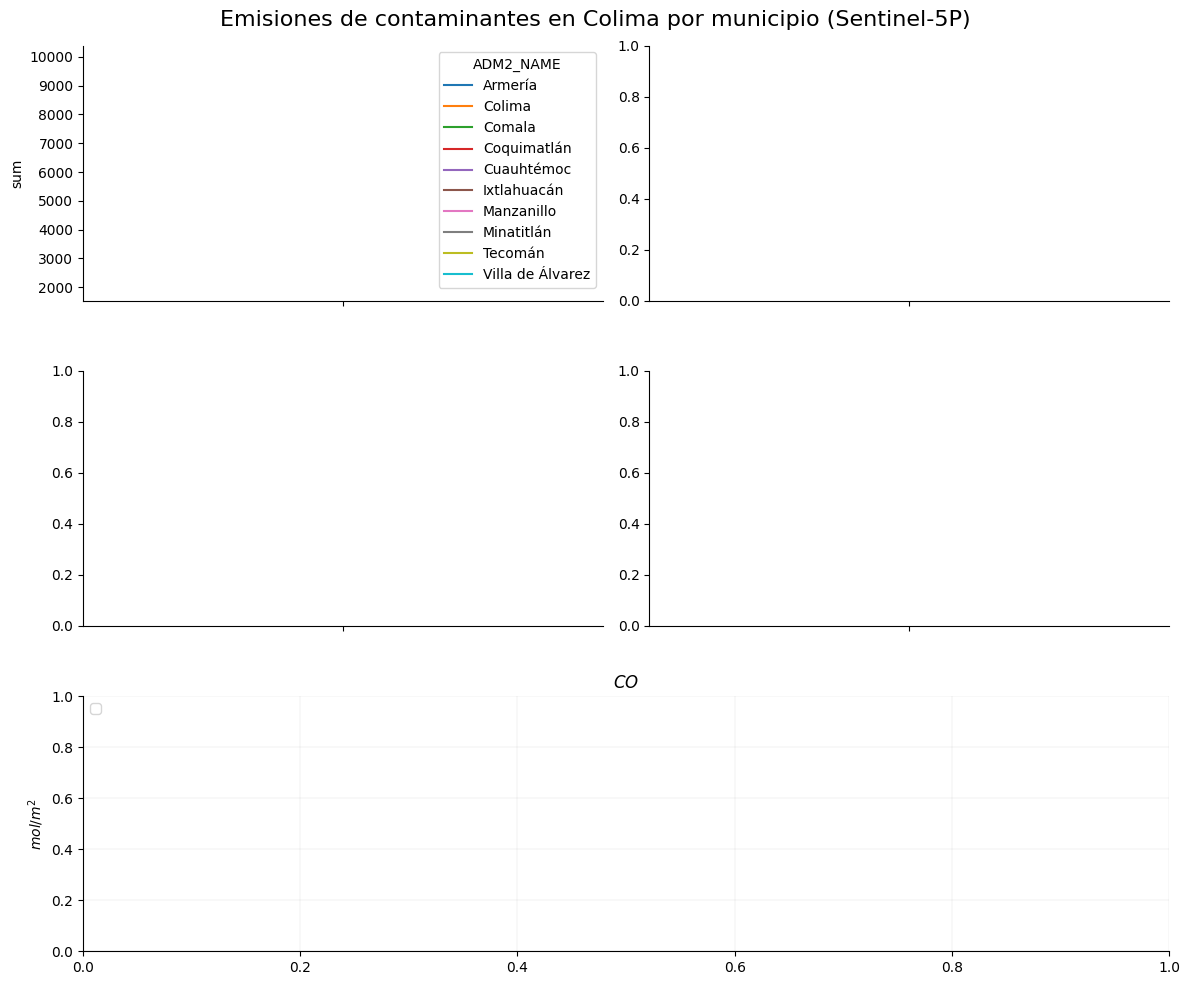

In [162]:
nQuimicos = len(dfMunSentinel["quimico"].unique())

fig, ax = plt.subplots(figsize=(12, 10), ncols=2, nrows=3, sharex=True)

col = 0
row = 0
gs = ax[2,0].get_gridspec()

for emision, quimicoDF in dfMunSentinel.groupby("quimico"):
  break
  ax[row, col].set_title(emision, fontweight="bold")
  #sns.barplot(x="ADM2_NAME", y="sum", data=quimicoDF, ax=ax[row, col])
  sns.lineplot(x='date', y='sum', data=quimicoDF, ax=ax[row, col], hue="ADM2_NAME")
  
  ax[row, col].set_xlabel("")
  ax[row, col].set_ylabel("$mol/m^2$")
  # set ylim 10% higher than max value in "emisiones" column
  ax[row, col].grid(color='gray', linestyle='-', linewidth=0.1, alpha=0.7)  
  
  # set hline for national average 

  ax[row, col].legend().set_visible(False)
  
  col += 1
  if col == 2:
    col = 0
    row += 1
    
    
for axe in ax[2,:]:
    axe.remove()
    
axbig = fig.add_subplot(gs[2, :])


axbig.set_title(emision, fontweight="bold")
sns.lineplot(x='date', y='sum', data=quimicoDF, ax=ax[row, col], hue="ADM2_NAME")

axbig.set_xlabel("")
axbig.set_ylabel("$mol/m^2$")
axbig.grid(color='gray', linestyle='-', linewidth=0.1, alpha=0.7)
#axbig.legend(ncol=5, loc="upper center", bbox_to_anchor=(0.5, -0.25), fancybox=True)
axbig.legend(fancybox=True, loc="upper left")

# Increase space between subplots
fig.subplots_adjust(hspace=0.5)
fig.suptitle("Emisiones de contaminantes en Colima por municipio (Sentinel-5P)", fontsize=16) 
sns.despine()
plt.tight_layout()

plt.show()

In [163]:
quimicoDF

,ADM2_NAME,Shape_Area,sum,date,quimico
200,Armería,0.047960,4344.453652,2022,$CO$
201,Colima,0.059419,4973.070387,2022,$CO$
202,Comala,0.025622,1934.415522,2022,$CO$
203,Coquimatlán,0.041502,3567.721559,2022,$CO$
204,Cuauhtémoc,0.040930,3214.169825,2022,$CO$
205,Ixtlahuacán,0.023952,2050.837486,2022,$CO$
206,Manzanillo,0.112299,9992.371783,2022,$CO$
207,Minatitlán,0.028794,2164.940167,2022,$CO$
208,Tecomán,0.072650,6540.103739,2022,$CO$
209,Villa de Álvarez,0.026186,2123.281656,2022,$CO$


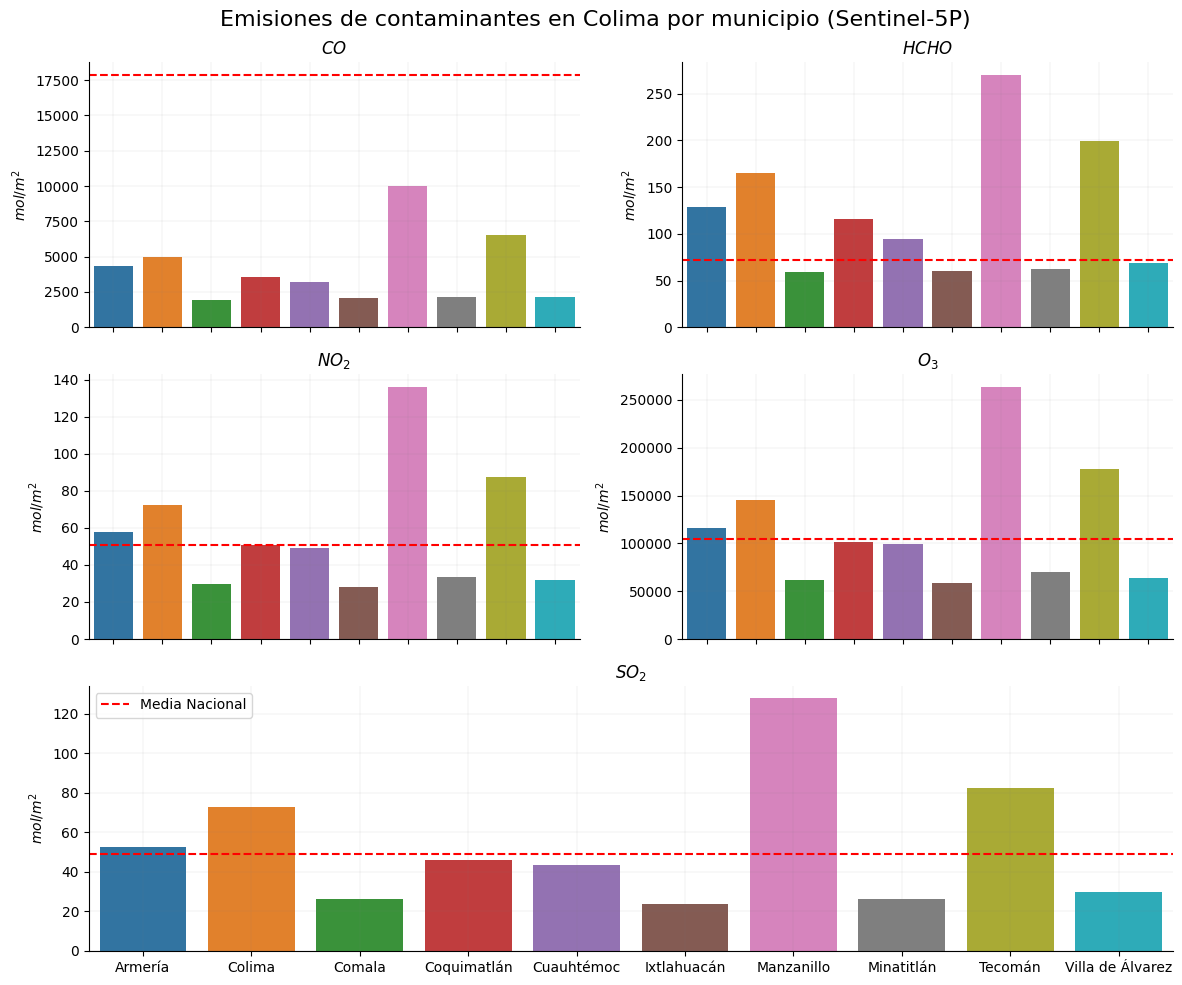

In [154]:
nQuimicos = len(dfMunSentinel_groupes["quimico"].unique())

fig, ax = plt.subplots(figsize=(12, 10), ncols=2, nrows=3, sharex=True)

col = 0
row = 0
gs = ax[2,0].get_gridspec()

for emision, quimicoDF in dfMunSentinel_groupes.groupby("quimico"):
  
  ax[row, col].set_title(emision, fontweight="bold")
  sns.barplot(x="ADM2_NAME", y="sum", data=quimicoDF, ax=ax[row, col])
  ax[row, col].set_xlabel("")
  ax[row, col].set_ylabel("$mol/m^2$")
  # set ylim 10% higher than max value in "emisiones" column
  ax[row, col].grid(color='gray', linestyle='-', linewidth=0.1, alpha=0.7)  
  
  # set hline for national average 
  ax[row, col].axhline(medias_nacionales_dict[emision][0], color="red", linestyle="--", label="Media Nacional")
  ax[row, col].legend().set_visible(False)
  
  col += 1
  if col == 2:
    col = 0
    row += 1
    
    
for axe in ax[2,:]:
    axe.remove()
    
axbig = fig.add_subplot(gs[2, :])


axbig.set_title(emision, fontweight="bold")
sns.barplot(x="ADM2_NAME", y="sum", data=quimicoDF, ax=axbig)
axbig.axhline(medias_nacionales_dict[emision][0], color="red", linestyle="--", label="Media Nacional")
axbig.set_xlabel("")
axbig.set_ylabel("$mol/m^2$")
axbig.grid(color='gray', linestyle='-', linewidth=0.1, alpha=0.7)
#axbig.legend(ncol=5, loc="upper center", bbox_to_anchor=(0.5, -0.25), fancybox=True)
axbig.legend(fancybox=True, loc="upper left")

# Increase space between subplots
fig.subplots_adjust(hspace=0.5)
fig.suptitle("Emisiones de contaminantes en Colima por municipio (Sentinel-5P)", fontsize=16) 
sns.despine()
plt.tight_layout()

plt.show()

## Datos de AGEBS (mensuales por ageb)

In [61]:
agebs_files = glob.glob("data/sentinel/AGEBS/month/*.csv")
print(len(agebs_files))
agebs_files[:5]

255


['data/sentinel/AGEBS/month\\sum_CO_2018-11-01.csv',
 'data/sentinel/AGEBS/month\\sum_CO_2018-12-01.csv',
 'data/sentinel/AGEBS/month\\sum_CO_2019-01-01.csv',
 'data/sentinel/AGEBS/month\\sum_CO_2019-02-01.csv',
 'data/sentinel/AGEBS/month\\sum_CO_2019-03-01.csv']

In [81]:
def readAgebMonthly(path, dfFull):
  df = pd.read_csv(path)
  df.drop(columns=["system:index"], inplace=True)
  name_Quimico = path.split("_")[1].lower()
  
  date = path.split("_")[2][:10]
  
  df['quimico'] = replace_emision[name_Quimico]
  df['date'] = pd.to_datetime(date)
  
  df = pd.concat([dfFull, df], axis=0, ignore_index=True)
  return df

dfFullAgebs = pd.DataFrame()

for path in agebs_files:
  dfFullAgebs = readAgebMonthly(path, dfFullAgebs)
print(dfFullAgebs.quimico.unique())
dfFullAgebs

['$CO$' '$HCHO$' '$NO_2$' '$O_3$' '$SO_2$']


,sum,CVE_LOC,CVE_MUN,CVE_ENT,CVEGEO,CVE_AGEB,quimico,date
0,0.052075,1,1,6,0600100010081,0081,$CO$,2018-11-01
1,0.023302,1,1,6,060010001019A,019A,$CO$,2018-11-01
2,0.008745,1,1,6,0600100010359,0359,$CO$,2018-11-01
3,0.077275,1,1,6,0600100010151,0151,$CO$,2018-11-01
4,0.076924,1,1,6,0600100010166,0166,$CO$,2018-11-01
...,...,...,...,...,...,...,...,...
140500,0.000618,1,10,6,0601000011017,1017,$SO_2$,2022-11-01
140501,-0.000151,1,10,6,0601000011178,1178,$SO_2$,2022-11-01
140502,-0.000315,1,10,6,0601000011144,1144,$SO_2$,2022-11-01
140503,-0.000038,1,10,6,060100001113A,113A,$SO_2$,2022-11-01


In [82]:
dfFullAgebs = pd.merge(dfFullAgebs, agebs_colima, on=["CVEGEO", "CVE_ENT", "CVE_MUN", "CVE_LOC","CVE_AGEB"])
dfFullAgebs

,sum,CVE_LOC,CVE_MUN,CVE_ENT,CVEGEO,CVE_AGEB,quimico,date,area,NOM_ENT,NOM_MUN,NOM_LOC,Ámbito
0,0.052075,1,1,6,0600100010081,0081,$CO$,2018-11-01,0.28,Colima,Armería,Ciudad de Armería,U
1,0.151151,1,1,6,0600100010081,0081,$CO$,2018-12-01,0.28,Colima,Armería,Ciudad de Armería,U
2,0.211080,1,1,6,0600100010081,0081,$CO$,2019-01-01,0.28,Colima,Armería,Ciudad de Armería,U
3,0.226947,1,1,6,0600100010081,0081,$CO$,2019-02-01,0.28,Colima,Armería,Ciudad de Armería,U
4,0.272456,1,1,6,0600100010081,0081,$CO$,2019-03-01,0.28,Colima,Armería,Ciudad de Armería,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...
140500,0.001144,1,10,6,0601000011375,1375,$SO_2$,2022-07-01,0.22,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U
140501,0.000199,1,10,6,0601000011375,1375,$SO_2$,2022-08-01,0.22,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U
140502,0.000378,1,10,6,0601000011375,1375,$SO_2$,2022-09-01,0.22,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U
140503,0.000413,1,10,6,0601000011375,1375,$SO_2$,2022-10-01,0.22,Colima,Villa de Álvarez,Ciudad de Villa de Álvarez,U


In [83]:
dfFullAgebs_total = dfFullAgebs.groupby(["NOM_MUN","quimico"]).agg({"sum": "sum",'area':"sum"}).reset_index()
dfFullAgebs_total

,NOM_MUN,quimico,sum,area
0,Armería,$CO$,245.221375,333.20
1,Armería,$HCHO$,1.682923,340.00
2,Armería,$NO_2$,0.711560,360.40
3,Armería,$O_3$,1410.888905,360.40
4,Armería,$SO_2$,0.634078,340.00
5,Colima,$CO$,1473.174679,2047.22
6,Colima,$HCHO$,10.463643,2089.00
7,Colima,$NO_2$,4.835622,2214.34
8,Colima,$O_3$,8698.290680,2214.34
9,Colima,$SO_2$,4.080716,2089.00
